# Model Interepretability: Churn Key Driver Analysis

Notebook Contents:
* [EDA](#scrollTo=03asMvbvwinC)
* [Data Overview](#scrollTo=HtYdoF-M0C_k)
* [Data Preprocessing](#scrollTo=-pmv9kZAJsox)
* [Evaluation Metrics](#scrollTo=DS1j8mETT0VG)
* [Feature Importance - Global](#scrollTo=CIt5qhbE-14D)
* [Feature Importance - Local](#scrollTo=T5FsyHiA-_KZ)
* [Permuation Feature Importance](#scrollTo=3EmYxZbnLT_a)
* [Partial Dependence Plots](#scrollTo=h1d5yxLcTDJ7)
* [ICE Plots](#scrollTo=ACGNg9DL7_dU&line=1&uniqifier=1)
* [Accumulated Local Effects (ALE)](#scrollTo=BTK2WYxaAC0x&line=1&uniqifier=1)
* [SHAP](#scrollTo=ajWrnFPdC7rw&line=1&uniqifier=1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # or any classifier
import warnings
import math
# warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Google Drive: Mounting Google Drive locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read from
path = '/content/drive/MyDrive/Colab/Datasets/telco-customer-churn.csv'
# path = '/data/telco-customer-churn.csv'

df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype('float')
df.reset_index(drop=True, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# EDA

## Categorical Feature Analysis

Overall target mean: 26.58%


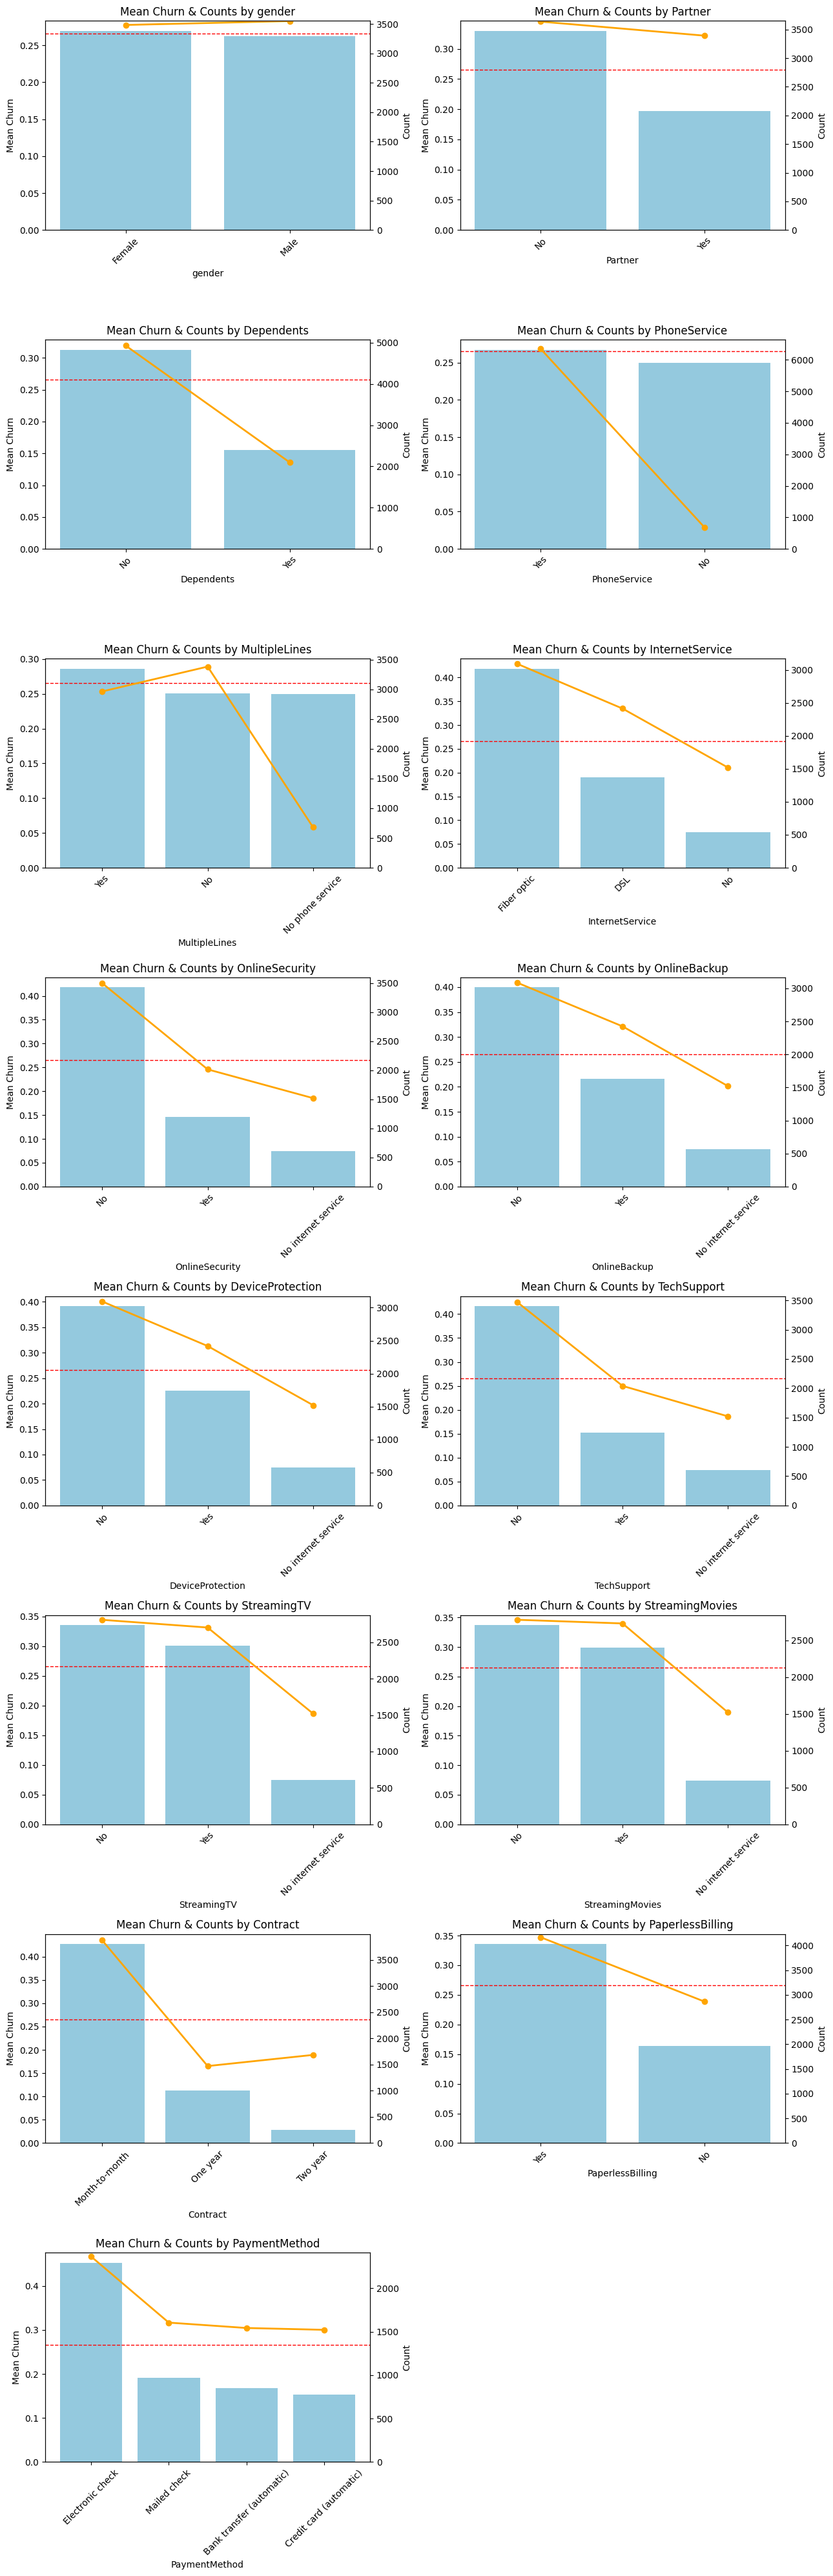

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mean target
target = 'Churn'
mean_target = df[target].mean()
print(f"Overall target mean: {mean_target:.2%}")


# Number of plots and grid shape
cols_to_remove = ['customerID']
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
filtered_cols = [item for item in cat_cols if item not in cols_to_remove]
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Plot mean target and counts across all categorical variables
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.5, rows * 5))
axes = axes.flatten()

for i, col in enumerate(filtered_cols):
    # Calculate mean target and counts per category
    grouped = df.groupby(col).agg(
        mean_target=(target, 'mean'),
        count=(target, 'size')
    ).reset_index()

    # Sort categories by mean target for clarity
    grouped = grouped.sort_values(by='mean_target', ascending=False)

    # Create primary bar plot for mean target
    sns.barplot(data=grouped, x=col, y='mean_target', ax=axes[i], color="skyblue")

    # Create a secondary Y-axis for counts (line plot)
    ax2 = axes[i].twinx()
    ax2.plot(
        grouped[col],
        grouped['count'],
        color='orange',
        marker='o',
        linewidth=2,
        label='Count'
    )

    # Set secondary Y-axis to start at 0
    ax2.set_ylim(bottom=0)

    # Add reference line for overall mean target on primary Y-axis
    axes[i].axhline(mean_target, color='red', linestyle='--', linewidth=1)

    # Set labels and titles
    axes[i].set_title(f'Mean {target} & Counts by {col}')
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_xlabel(col)
    ax2.set_ylabel("Count")

    # Rotate category labels for readability
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

## Numeric Feature Analysis

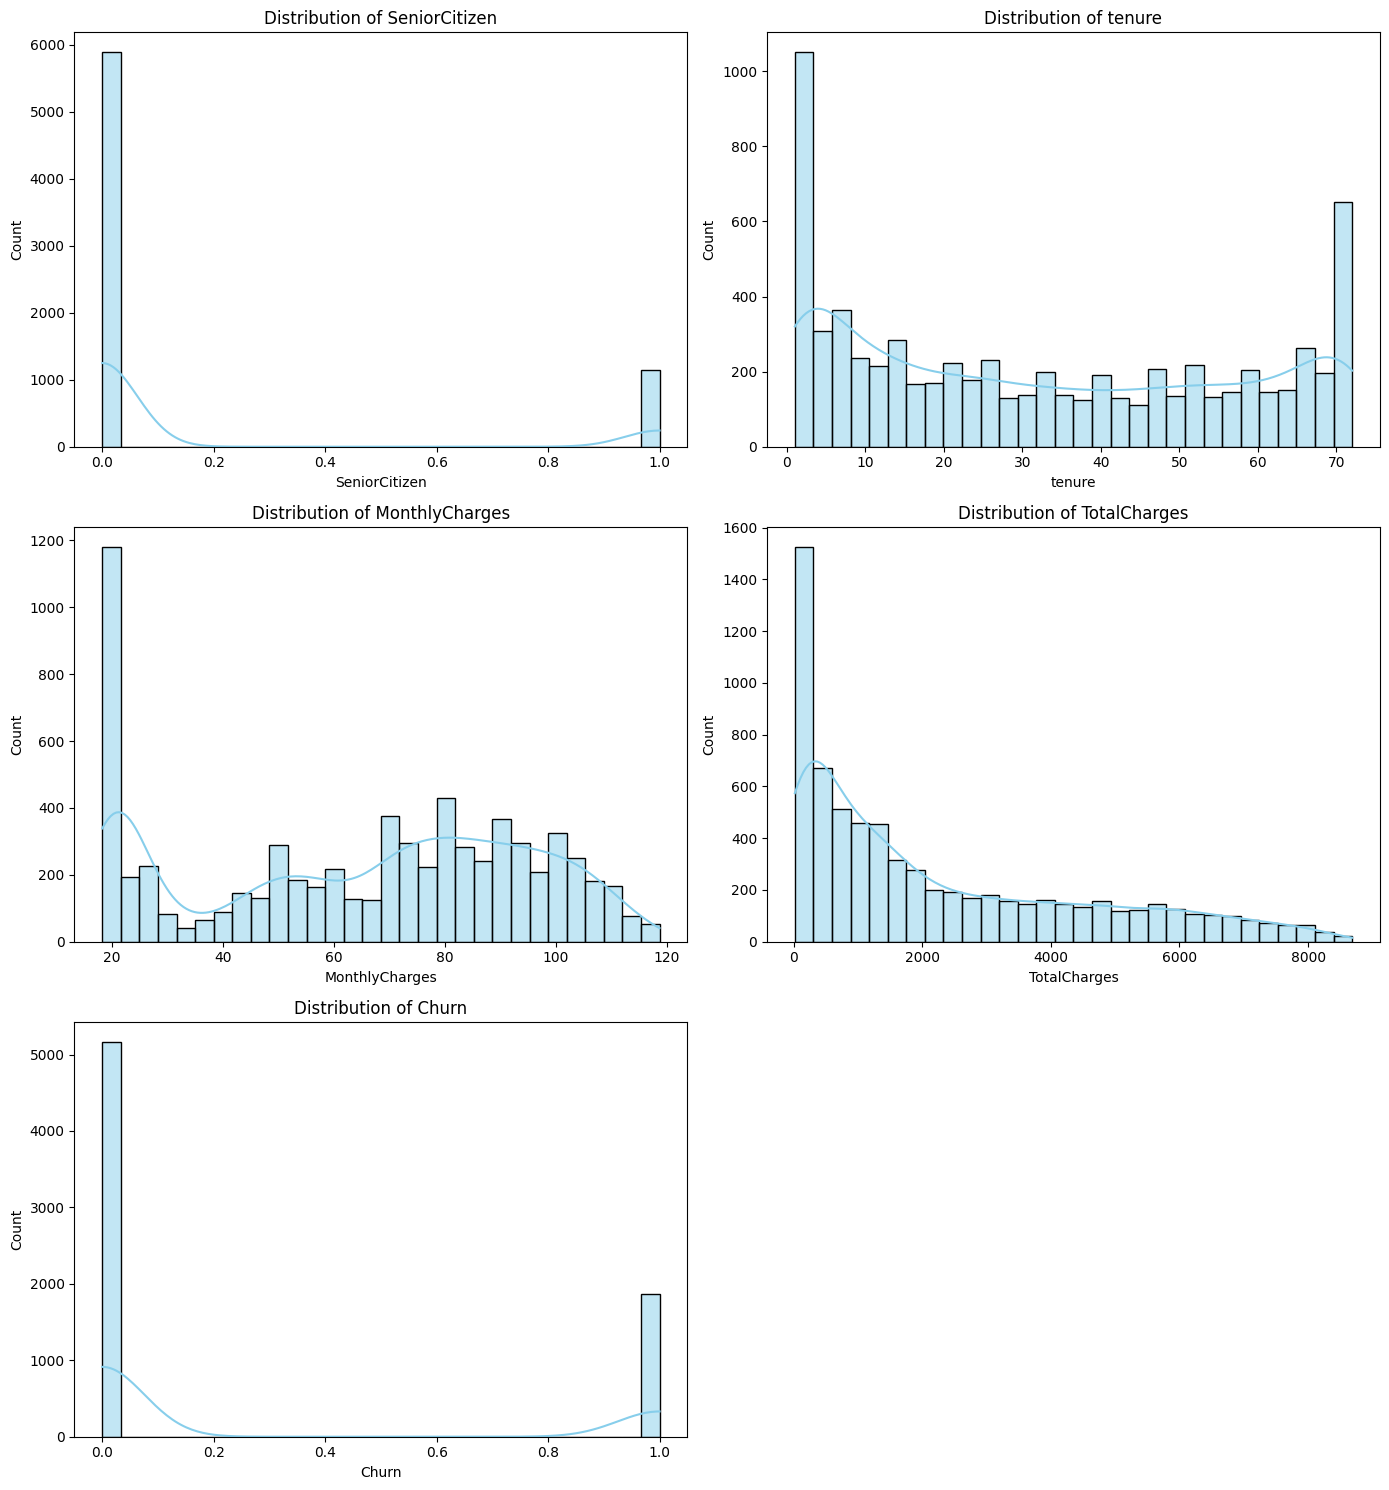

In [ ]:
# # Optional: columns to exclude
# cols_to_remove = ['customerID', 'some_other_column']  # <-- adjust as needed

# Select numeric features
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature with KDE
for i, col in enumerate(filtered_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

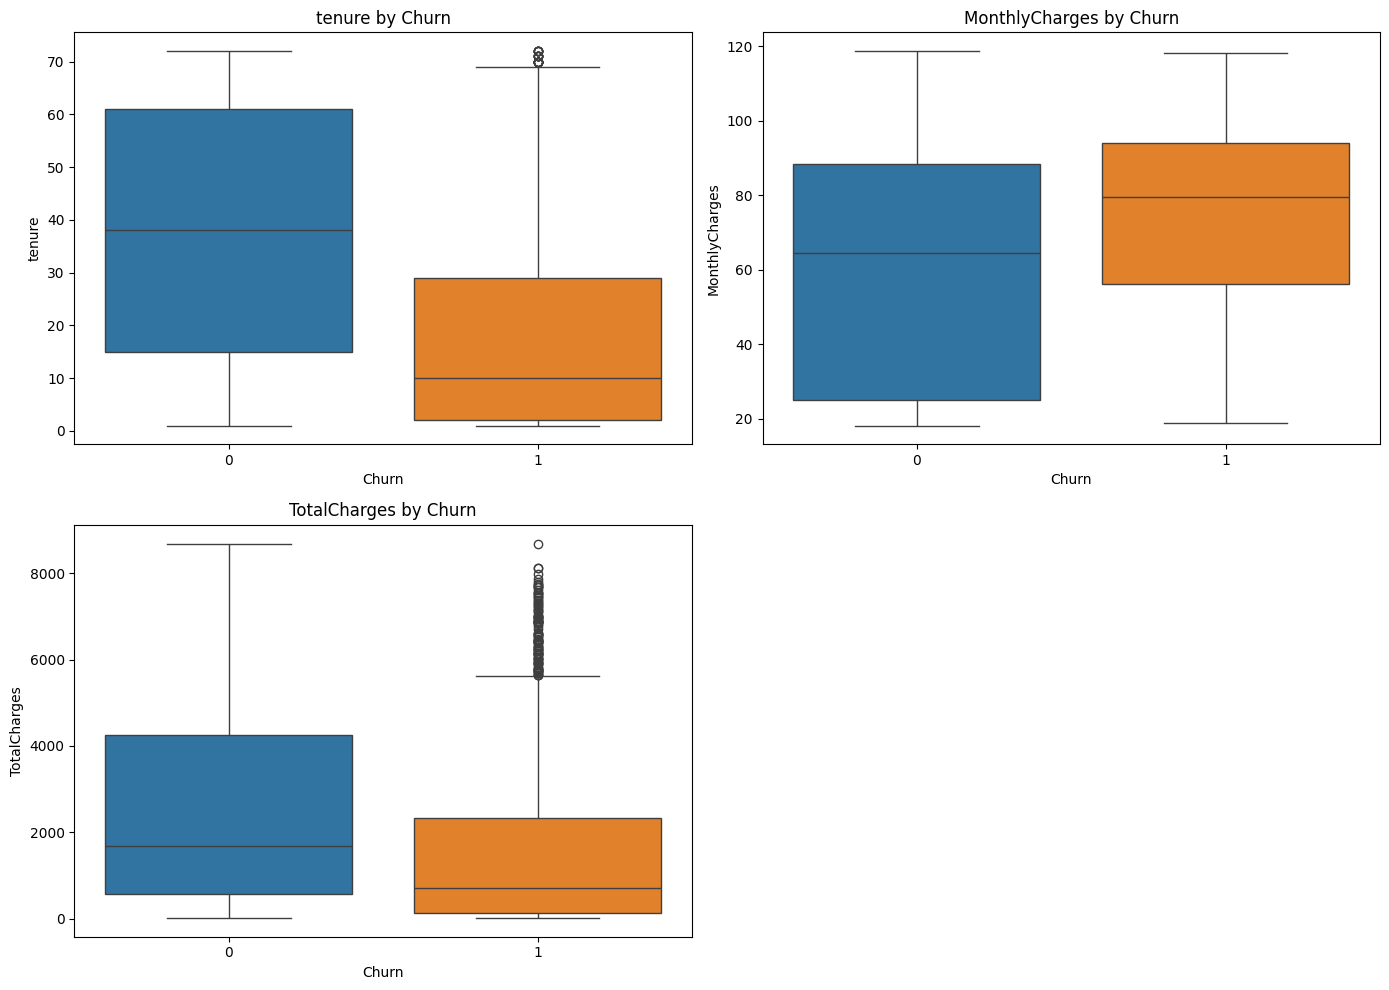

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Define your target variable
target = 'Churn'  # Replace with your actual target name

# Optional: columns to exclude
cols_to_remove = ['Churn', 'SeniorCitizen']  # Customize this list

# Select numeric features (and remove excluded ones)
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature as a boxplot
for i, col in enumerate(filtered_cols):
    sns.boxplot(data=df, x=target, y=col, ax=axes[i], hue=target, legend=False)
    axes[i].set_title(f'{col} by {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(col)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

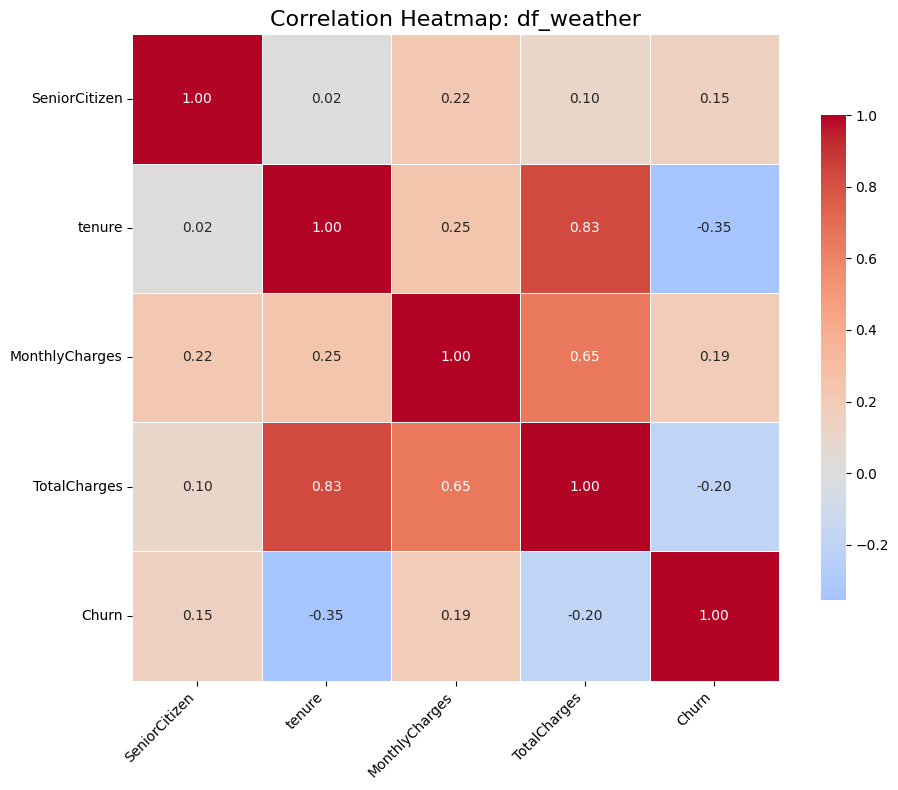

In [ ]:
# correlation matrix
corr_matrix = df.corr(numeric_only=True)  # Use numeric_only=True for pandas >=1.5

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Correlation Heatmap: df_weather", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Overview

Categorical (2 levels):
* gender
* Partner
* Dependents
* PhoneService
* PaperlessBilling

Categorical (>2 levels):
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies
* Contract
* PaymentMethod

Numeric:
* SeniorCitizen
* tenure
* MonthlyCharges
* TotalCharges

Target
* Churn (Categorical - 2 levels)





---

# Data Preparation

In [ ]:
df['Contract'] = df['Contract'].map({'Month-to-month': 1, 'One year': 2, 'Two year': 3})
df['PaymentMethod_ElectCheck'] = df['PaymentMethod'].map(lambda x: 1 if x =='Electronic check' else 0)
df['InternetService'] = df['InternetService'].map({'No': 1, 'DSL': 2, 'Fiber optic': 3})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
df['OnlineBackup'] = df['OnlineBackup'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
df['DeviceProtection'] = df['DeviceProtection'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
df['TechSupport'] = df['TechSupport'].map({'No internet service': 1, 'Yes': 2, 'No': 3})

In [ ]:
# df['Contract'] = df['Contract'].map({'Month-to-month': 1, 'One year': 2, 'Two year': 3})
# df['PaymentMethod_ElectCheck'] = df['PaymentMethod'].map(lambda x: 1 if x =='Electronic check' else 0)
# df['InternetService'] = df['InternetService'].map({'No': 2, 'DSL': 1, 'Fiber optic': 3})
# df['OnlineSecurity'] = df['OnlineSecurity'].map({'No internet service': 2, 'Yes': 3, 'No': 1})
# df['OnlineBackup'] = df['OnlineBackup'].map({'No internet service': 1, 'Yes': 2, 'No': 3})
# df['DeviceProtection'] = df['DeviceProtection'].map({'No internet service': 3, 'Yes': 1, 'No': 2})
# df['TechSupport'] = df['TechSupport'].map({'No internet service': 3, 'Yes': 1, 'No': 2})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerID                7032 non-null   object 
 1   gender                    7032 non-null   object 
 2   SeniorCitizen             7032 non-null   int64  
 3   Partner                   7032 non-null   object 
 4   Dependents                7032 non-null   object 
 5   tenure                    7032 non-null   int64  
 6   PhoneService              7032 non-null   object 
 7   MultipleLines             7032 non-null   object 
 8   InternetService           7032 non-null   int64  
 9   OnlineSecurity            7032 non-null   int64  
 10  OnlineBackup              7032 non-null   int64  
 11  DeviceProtection          7032 non-null   int64  
 12  TechSupport               7032 non-null   int64  
 13  StreamingTV               7032 non-null   object 
 14  Streamin

# Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # or any classifier

In [ ]:
target = ['Churn']
cols_to_drop = [
                'customerID', 'PaymentMethod', 'SeniorCitizen', 'TotalCharges',
                'gender', 'Partner', 'Dependents','PhoneService','PaperlessBilling',
                'MultipleLines', 'StreamingTV','StreamingMovies',
                  ]

binary_int_cols = ['PaymentMethod_ElectCheck']

ordinal_int_cols = [
'Contract',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
]

numeric_cols = [
'tenure',
'MonthlyCharges',
# 'TotalCharges',
]

# binary_categorical_cols = [
# 'gender',
# 'Partner',
# 'Dependents',
# 'PhoneService',
# 'PaperlessBilling'
# ]

# categorical_cols = [
# # 'MultipleLines',
# 'InternetService',
# 'OnlineSecurity',
# 'OnlineBackup',
# 'DeviceProtection',
# 'TechSupport',
# # 'StreamingTV',
# # 'StreamingMovies',
# # 'PaymentMethod',
# ]

In [ ]:
# --- 1. Split features and target ---
drop_cols = cols_to_drop + target
X = df.drop(columns=drop_cols)
y = df[target]

In [ ]:
X.head()

,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,PaymentMethod_ElectCheck
0,1,2,3,2,3,3,1,29.85,1
1,34,2,2,3,2,3,2,56.95,0
2,2,2,2,2,3,3,1,53.85,0
3,45,2,2,3,2,2,2,42.30,0
4,2,3,3,3,3,3,1,70.70,1


In [ ]:
print(X.shape)
print(y.shape)

(7032, 9)
(7032, 1)


In [ ]:
# --- 2. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5625, 9)
(1407, 9)
(5625, 1)
(1407, 1)


In [ ]:
# # --- 3. Define transformers ---
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
# ])
#     # Silently ignore unknown categories at transform time
#     # Drop one of the two levels of a categorical feature only if that feature has exactly two categories

In [ ]:
# # --- 4. Column transformer for preprocessing ---
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_cols),
#         # ('bin_cat', categorical_transformer, binary_categorical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ],
#     remainder='passthrough'  # Let binary_int_cols and ordinary_int_cols through as-is
# )

In [ ]:
# # --- 5. Fit preprocessing pipeline only ---
# preprocessor.fit(X_train)

In [ ]:
# print(preprocessor.n_features_in_)
# print(preprocessor.feature_names_in_)

In [ ]:
# preprocessor.get_feature_names_out()

In [ ]:
# preprocessor.get_params()

In [ ]:
# # --- 6. Transform train and test data ---
# X_train_preprocessed = preprocessor.transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# --- 7. Fit model separately ---
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
# model = GradientBoostingClassifier(n_estimators=100, random_state=42
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [ ]:
# --- 8. Predict on test set ---
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# provides probablity for each class
y_pred_prob = model.predict_proba(X_test)

In [ ]:
print(y_pred_prob.shape)
print(model.classes_)
y_pred_prob

(1407, 2)
[0 1]


array([[0.96146236, 0.03853764],
       [0.33923676, 0.66076324],
       [0.98150228, 0.01849772],
       ...,
       [0.95139877, 0.04860123],
       [0.97318334, 0.02681666],
       [0.97958331, 0.02041669]])

In [ ]:
pd.DataFrame(y_pred_prob).describe()

,0,1
count,1407.000000,1407.000000
mean,0.727661,0.272339
std,0.230036,0.230036
min,0.187614,0.017248
25%,0.558231,0.058608
50%,0.783537,0.216463
75%,0.941392,0.441769
max,0.982752,0.812386


---

# Evaluation Metrics

=== Metric Scores ===
Accuracy:  0.788
Precision: 0.644
Recall:    0.455
F1 Score:  0.533
ROC AUC:   0.828
PR AUC:    0.622


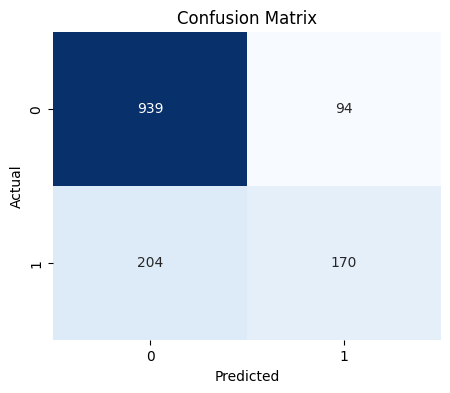

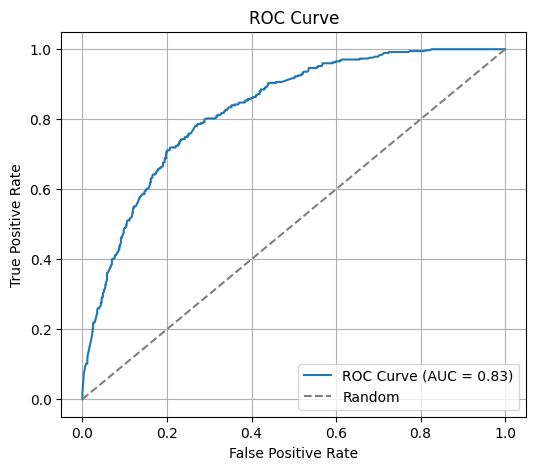

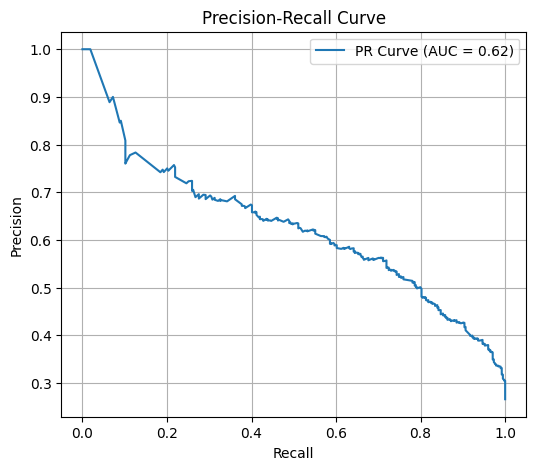


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.822     0.909     0.863      1033
           1      0.644     0.455     0.533       374

    accuracy                          0.788      1407
   macro avg      0.733     0.682     0.698      1407
weighted avg      0.774     0.788     0.775      1407


=== Classification Rates ===
True Positive Rate - Recall (% of actual positives correctly predicted)): 0.4545
True Negative Rate (% of actual negatives correctly predicted): 0.9090
Positive Prediction Rate - Precision (% of predicted positives correctly predicted): 0.6439
Negative Prediction Rate (% of predicted negatives correctly predicted): 0.8215


In [ ]:
# Binary Classification Metrics Visualization Script
# --------------------------------------------------
# Assumes:
# - `y_test`: true labels (0 or 1)
# - `y_pred`: predicted class labels from model
# - `y_pred_prob`: predicted probabilities from model.predict_proba(X_test)[:, 1]

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example placeholders (replace these with your real values)
# y_test = ...
# y_pred = ...

y_pred_prob = model.predict_proba(X_test)[:, 1]

# 1. Basic metric scores
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_prob)
avg_prec  = average_precision_score(y_test, y_pred_prob)

print("=== Metric Scores ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")
print(f"PR AUC:    {avg_prec:.3f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f'PR Curve (AUC = {avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# 5. Classification Report: Precision, Recall, F1, Accuray
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# 6. Classification Rates
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)  # True Positive Rate (Recall or Sensitivity)
tnr = tn / (tn + fp)  # True Negative Rate
ppr = tp / (tp + fp)  # Positive Prediction Rate (Precision)
npr = tn / (tn + fn)  # Negative Prediction Rate

print("\n=== Classification Rates ===")
print(f"True Positive Rate - Recall (% of actual positives correctly predicted)): {tpr:.4f}")
print(f"True Negative Rate (% of actual negatives correctly predicted): {tnr:.4f}")
print(f"Positive Prediction Rate - Precision (% of predicted positives correctly predicted): {ppr:.4f}")
print(f"Negative Prediction Rate (% of predicted negatives correctly predicted): {npr:.4f}")

## Precision, Recall, F1 for Different Probability Thresholds

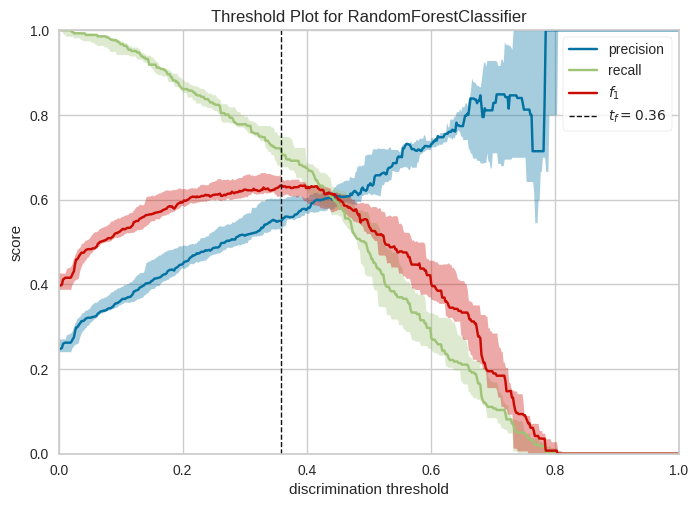

In [ ]:
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
)

visualizer = DiscriminationThreshold(model,
                                     n_trials=5, # Number of times to shuffle and split the dataset to account for noise in the threshold metrics curves
                                     cv=0.2, # float, to specify the percent of the test split
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

**Interpretation:**
* F1 score is maximized when the discrimination threshold is 0.36 (as opposed to the default of 0.5)
* When predicted probablity is above discrimination threshold, prediction is 1, else 0
* Lower threshold will lead to higher recall (True Positive Rate) but lead to more false postives, thus higher Predicted Postive Rate (Precision)
* What is the cost of `False Negative vs False Positive`
  * `False Negative`: User churn but model predicted they wouldn't churn
    * Miss intervention opportunity
  * `False Positive`: Model predicted user will churn but they didn't
    * Intervention and associated costs for non-churned users

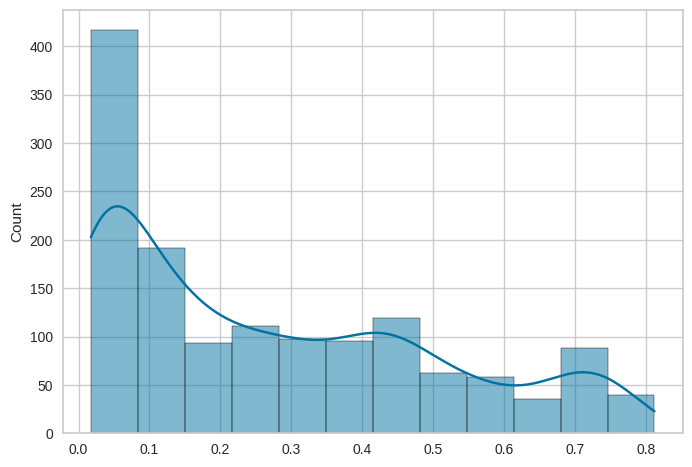

In [ ]:
sns.histplot(y_pred_prob, kde=True);

## False Positve Rate vs. False Negative Rate

               fpr       fnr
0.000000  1.000000  0.000000
0.010101  1.000000  0.000000
0.020202  0.940949  0.000000
0.030303  0.830591  0.000000
0.040404  0.736689  0.008021


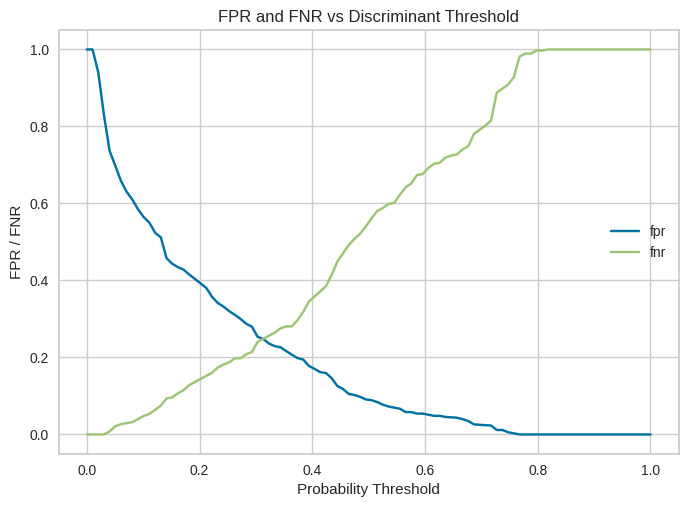

In [ ]:
fpr_ls = []
fnr_ls = []

# obtain probabilities
probs = model.predict_proba(X_test)[:,1]

thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:

    # obtain class prediction based on threshold
    preds = np.where(probs>=threshold, 1, 0)

    # obtain confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0,1]).ravel()

    #  obtain FRP and FNR
    FPR = fp / (tn + fp)
    FNR =  fn / (tp + fn)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)

metrics = pd.concat([
    pd.Series(fpr_ls),
    pd.Series(fnr_ls)], axis=1)

metrics.columns = ['fpr', 'fnr']
metrics.index = thresholds

print(metrics.head())
metrics.plot()
plt.xlabel('Probability Threshold')
plt.ylabel('FPR / FNR')
plt.title('FPR and FNR vs Discriminant Threshold');

**Interpretation:**
* `False Negative Rate`: % of actual positives that were incorrectly predicted
* `False Positive Rate`: % of actual negatives that were incorrectly predicted

In [ ]:
pd.DataFrame(y_pred_prob).describe()

,0
count,1407.000000
mean,0.272339
std,0.230036
min,0.017248
25%,0.058608
50%,0.216463
75%,0.441769
max,0.812386


In [ ]:
# baseline accuracy
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8053333333333333
0.7882018479033405


In [ ]:
# accuracy of naive model, mean of target
baseline = 1 - y_train.mean()
baseline

,0
Churn,0.734222


---

# Feature Importance - Global

In [ ]:
# get feature importances
print(model.n_features_in_)
print(len(model.feature_importances_))
print(model.feature_importances_)

9
9
[0.24334934 0.07628463 0.18616336 0.0128354  0.00299044 0.101184
 0.27319097 0.08115916 0.02284271]


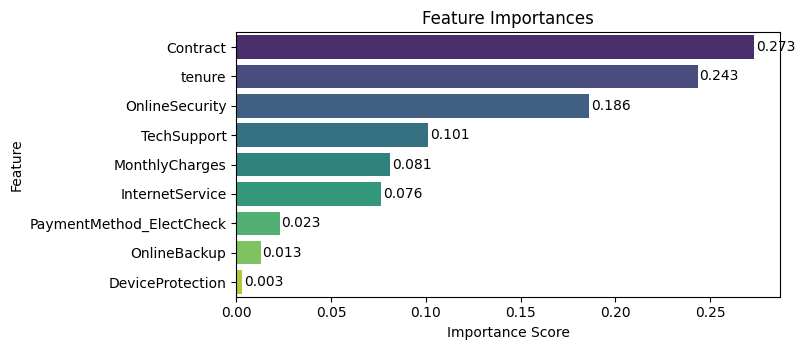

In [ ]:
# get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create a pandas Series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(feature_names) * 0.4))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
ax = sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')

plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
# Add labels to the bars
for i, v in enumerate(feat_imp):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center')

plt.show()

* Intuition: Features at top of tree, features used to split more often, and features that increase node purity have higher importance
* Feature importance in tree-based models reflects how much a feature contributes to reducing prediction error or impurity (e.g., Gini, MSE) across all trees and splits.

# Local Explainability

In [ ]:
# examine non-churned user
index = 0
print(y_test.iloc[index])
print(y_pred[index])
print(y_pred_prob[index])
X_test.iloc[index]

Churn    0
Name: 971, dtype: int64
0
0.03853764204914732


,971
tenure,59.00
InternetService,2.00
OnlineSecurity,3.00
OnlineBackup,2.00
DeviceProtection,3.00
TechSupport,2.00
Contract,3.00
MonthlyCharges,75.95
PaymentMethod_ElectCheck,0.00


In [ ]:
!pip install treeinterpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(model, X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: U

In [ ]:
# predicted probability for positive/negative class
print(prediction.shape)
prediction

(1407, 2)


array([[0.96146236, 0.03853764],
       [0.33923676, 0.66076324],
       [0.98150228, 0.01849772],
       ...,
       [0.95139877, 0.04860123],
       [0.97318334, 0.02681666],
       [0.97958331, 0.02041669]])

In [ ]:
# bias is mean of 1/0 in the dataset
print(bias.shape)
bias

(1407, 2)


array([[0.73573333, 0.26426667],
       [0.73573333, 0.26426667],
       [0.73573333, 0.26426667],
       ...,
       [0.73573333, 0.26426667],
       [0.73573333, 0.26426667],
       [0.73573333, 0.26426667]])

In [ ]:
print(contributions.shape)
contributions

(1407, 9, 2)


array([[[ 0.06208789, -0.06208789],
        [ 0.02882282, -0.02882282],
        [-0.06198455,  0.06198455],
        ...,
        [ 0.13512479, -0.13512479],
        [ 0.00270312, -0.00270312],
        [ 0.02314414, -0.02314414]],

       [[-0.15194416,  0.15194416],
        [-0.05094771,  0.05094771],
        [-0.08447557,  0.08447557],
        ...,
        [-0.07590029,  0.07590029],
        [-0.01998875,  0.01998875],
        [ 0.01607509, -0.01607509]],

       [[ 0.0230449 , -0.0230449 ],
        [ 0.02209945, -0.02209945],
        [ 0.06165706, -0.06165706],
        ...,
        [ 0.08181506, -0.08181506],
        [ 0.00761018, -0.00761018],
        [ 0.00540763, -0.00540763]],

       ...,

       [[-0.035364  ,  0.035364  ],
        [ 0.02949721, -0.02949721],
        [ 0.06729836, -0.06729836],
        ...,
        [ 0.07759925, -0.07759925],
        [ 0.02362457, -0.02362457],
        [ 0.00461832, -0.00461832]],

       [[ 0.02617793, -0.02617793],
        [ 0.02209945, -0.02

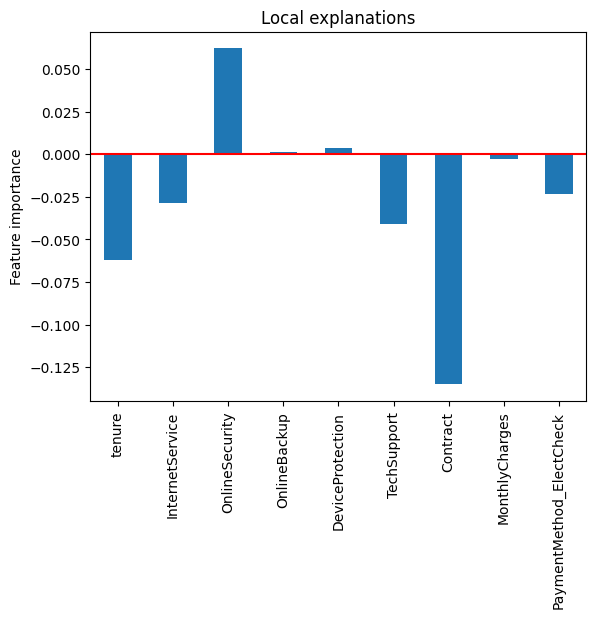

In [ ]:
# First sample

pd.Series(contributions[index][:, 1], index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

**Key Takeaways:**
* Strong negative relationship between Contract length and churn, this user is on a 2yr plan
* User has also been customer for 59 months, which results in lower probablity of churn

---

In [ ]:
# local explainability function
def local_tree_explainability(index, feature_names, y_test=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, contribution_array=contributions):
    print(f'Y Actual: {y_test.iloc[index]}')
    print('='*100)
    print(f'Y Prediction: {y_pred[index]}')
    print(f'Y Predicted Probablity: {y_pred_prob[index]}')
    print('='*100)
    print('Observation Features:')
    print(X_test.iloc[index])
    # print(df_X_test_preprocessed.loc[index])
    pd.Series(contribution_array[index][:, 1], index=feature_names).plot.bar()
    plt.axhline(y=0, color='r', linestyle='-')
    plt.ylabel("Feature importance")
    plt.title("Local explanations")
    plt.show()

Y Actual: Churn    0
Name: 971, dtype: int64
Y Prediction: 0
Y Predicted Probablity: 0.03853764204914732
Observation Features:
tenure                      59.00
InternetService              2.00
OnlineSecurity               3.00
OnlineBackup                 2.00
DeviceProtection             3.00
TechSupport                  2.00
Contract                     3.00
MonthlyCharges              75.95
PaymentMethod_ElectCheck     0.00
Name: 971, dtype: float64


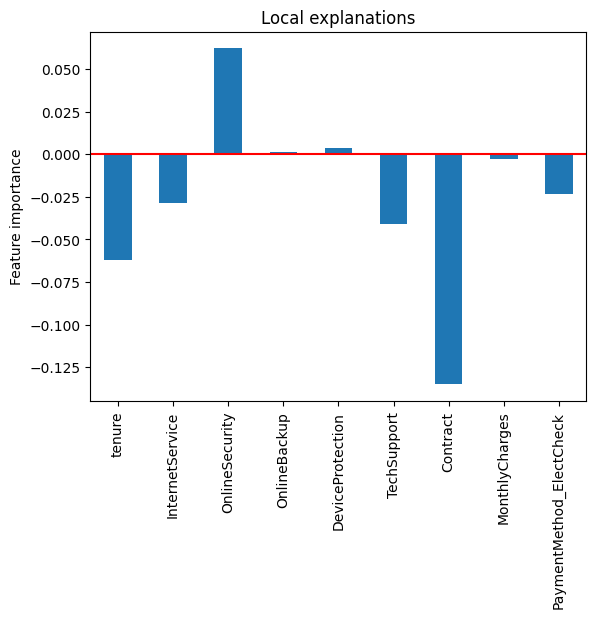

In [ ]:
local_tree_explainability(0, X_train.columns)

# Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    model,
    X_test, # we use the test set
    y_test,
    scoring= "neg_log_loss", # we can use any metric
    n_repeats=5, # number of times data within each features is randomly shuffled
    random_state=0,
)

In [ ]:
# contains is an array of arrays
# contains the individual importance of each repetition#
# and the mean and std

importance = pd.DataFrame(
    {"importance_mean": r["importances_mean"],
     "importance_std": r["importances_std"]},
    index=X_test.columns
)

importance

,importance_mean,importance_std
tenure,0.046475,0.002603
InternetService,0.014384,0.001862
OnlineSecurity,0.027355,0.003278
OnlineBackup,0.004834,0.001091
DeviceProtection,0.000492,0.000360
TechSupport,0.010516,0.001791
Contract,0.060193,0.004355
MonthlyCharges,0.011628,0.003463
PaymentMethod_ElectCheck,0.001978,0.000506


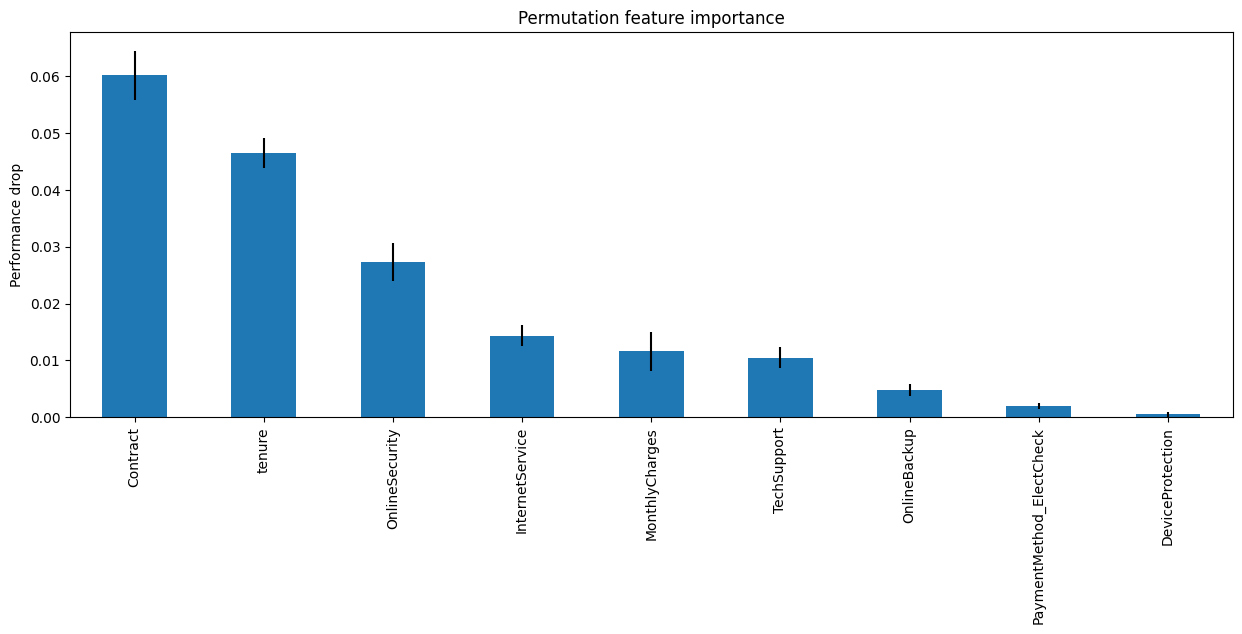

In [ ]:
# The larger the drop, the more important the feature

importance["importance_mean"].sort_values(
    ascending=False
).plot(figsize=(15, 5), kind="bar", yerr=importance["importance_std"])

plt.title("Permutation feature importance")
plt.ylabel("Performance drop")
plt.show()

* Feature importance calculated by randomly shuffling data within a given feature
* Measuring model performancedrop across all shuffled permutations
* Negatively affected by correlated features
* y-axis: avg. % drop in model performance metric
  * neg_log_los decreases by ~6% when `Contract` values are randomly shuffled

---

# Partial Dependence Plots - Numeric Feature

In [ ]:
# Let's put the code in a function

def plot_pdp_numeric(X, variable, bins=10):

    # to avoid modifying the original dataframe
    X = X.copy()

    # sort variable into bins
    bins = pd.cut(X[variable], bins=bins)

    # determine interval's middle point and n of observations
    pdp = X.groupby(bins, observed=False)[variable].agg(["mean", "count"])

    # calculate partial dependence
    pdp_preds = []
    for value in pdp["mean"]:
        X[variable] = value
        preds = model.predict(X)
        pdp_preds.append(np.mean(preds))
    pdp["pdp_preds"] = pdp_preds

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pdp_preds"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    ax2.set_ylim(bottom=0)
    plt.show();

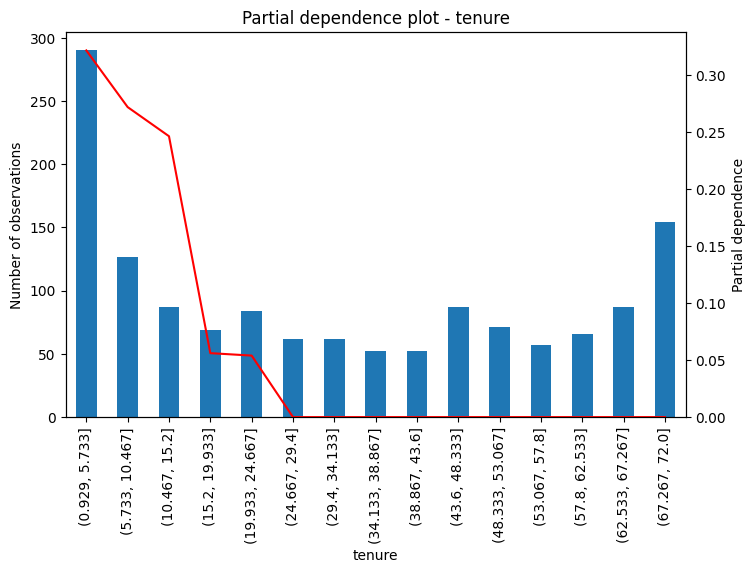

In [ ]:
warnings.filterwarnings("ignore")
plot_pdp_numeric(X_test, variable="tenure", bins=15);

* Iteratively set all feature obs to each feature value, make predictions for all obs at each level, holding all other features constant
* y-axis: mean predicted probablity of positive class
* Correlated features can impact results

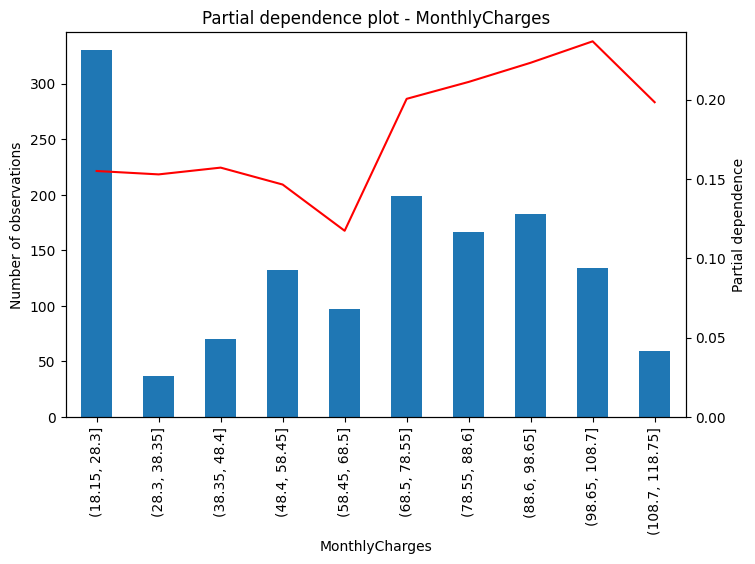

In [ ]:
plot_pdp_numeric(X_test, variable="MonthlyCharges", bins=10);

# Partial Dependence Plots - Categorical Feature

In [ ]:
# Let's put the code in a function

def plot_pdp_categorical(X, variable):

    # to avoid modifying the original dataframe
    X = X.copy()

    categories = X[variable].unique()
    categories.sort()

    pdp = pd.DataFrame({
    "count": X.groupby([variable])[variable].count(),
    }, index=categories)

    pdp_preds = []

    # calculate partial dependence
    for value in categories:

        # Set the feature to a fixed value
        X[variable] = value

        # Obtain the predictions
        preds = model.predict_proba(X)[:,1]

        # get the prediction average
        pdp_preds.append(np.mean(preds))

    # the predictions average
    pdp["pred"] = pdp_preds

    pdp.reset_index(inplace=True)

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pred"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    ax2.set_ylim(bottom=0)
    plt.xticks(pdp.index, pdp["index"])
    plt.show();

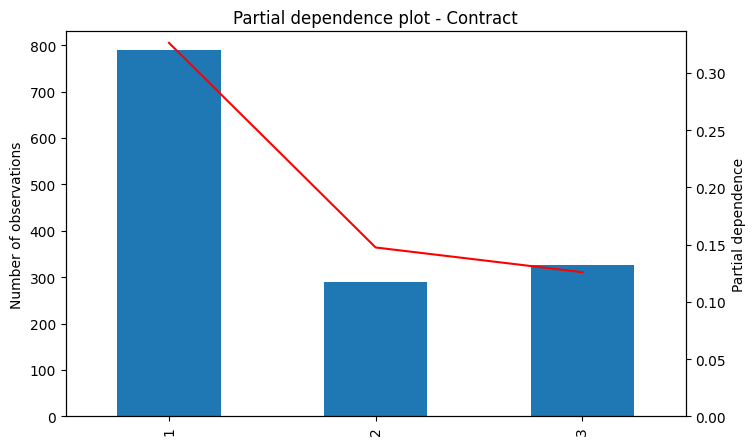

In [ ]:
plot_pdp_categorical(X_test, "Contract");

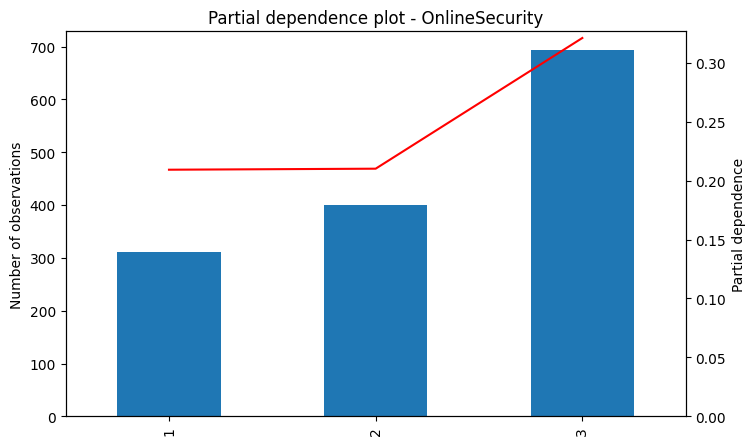

In [ ]:
plot_pdp_categorical(X_test, "OnlineSecurity");

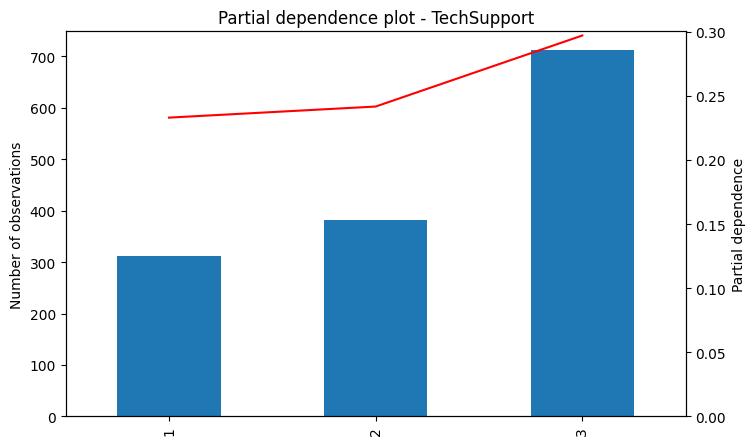

In [ ]:
plot_pdp_categorical(X_test, "TechSupport");

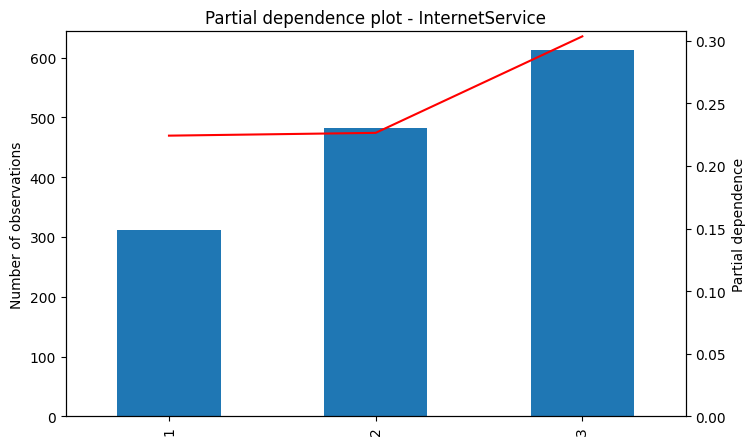

In [ ]:
plot_pdp_categorical(X_test, "InternetService");

# Individual Contribution Expectation (ICE)

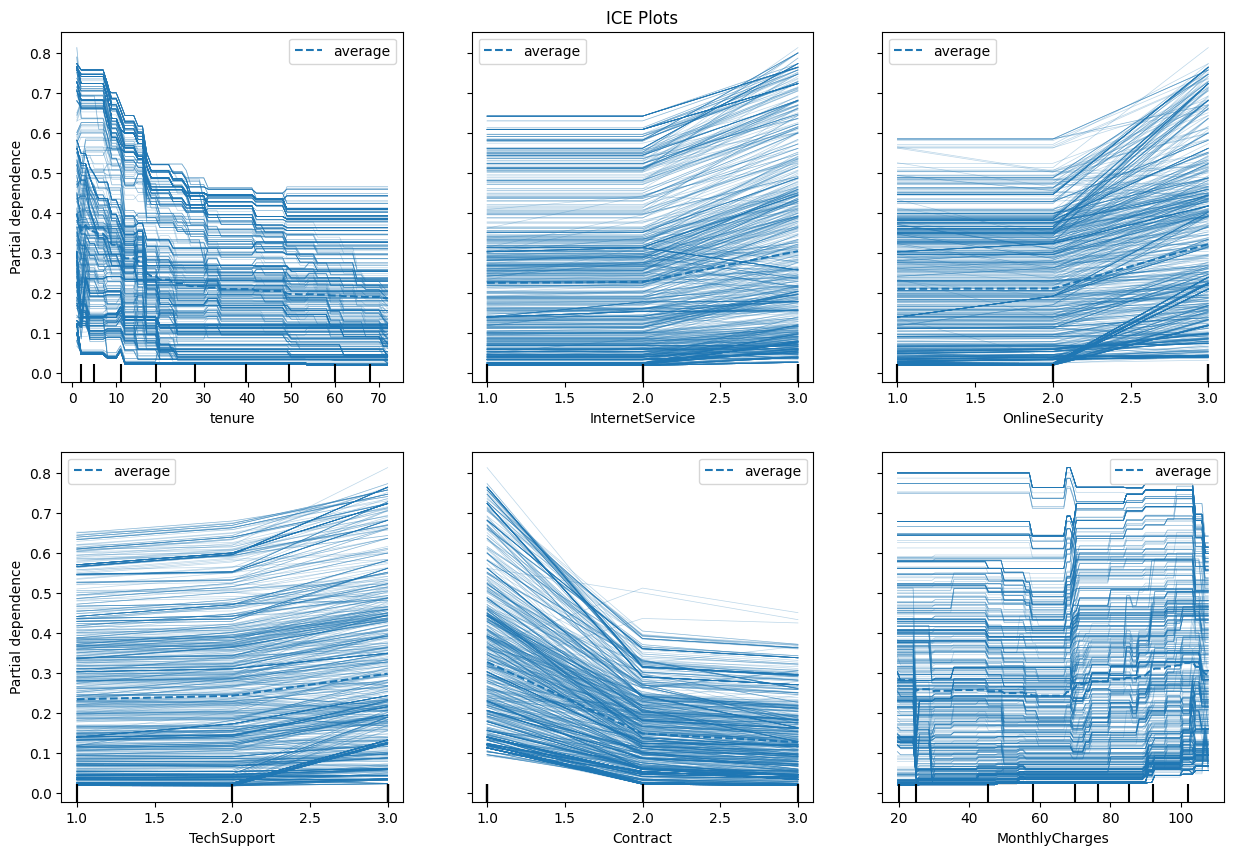

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("ICE Plots")

PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=(0, 1, 2, 5, 6, 7), # the features to plot
    kind = "both",
    random_state=5,
    ax=ax,
)

plt.show()

### Interpretation Notes
* Disaggregated Partial Dependence Plots
* y-axis: avg. predicted probability of churn
* Interpretation:
  * Large drop in pred proba when moving from Contract 1-2 (M-to-M -> 1-yr)
  * Across all variables, you tend to see a wide predicted probability range across all values of the feature
  * Which indicates that no feature by itself is especially predictive in predicting churn
    * Contract and tenure seem to be most predictive

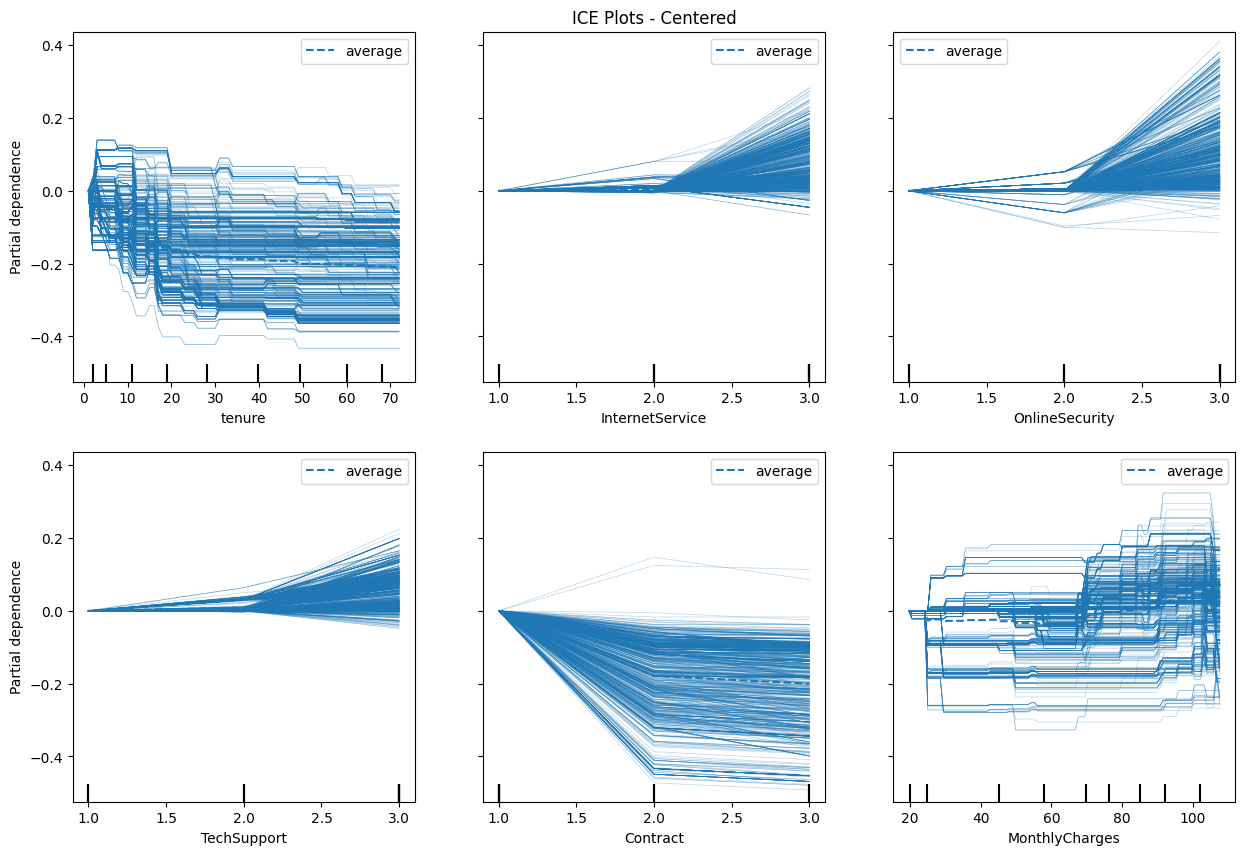

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("ICE Plots - Centered")

PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=(0, 1, 2, 5, 6, 7), # the features to plot
    kind = "both",
    random_state=5,
    centered=True,
    ax=ax,
)

plt.show()

* Plot is centered at the mean/median predicted probability for each feature


# Accumulated Local Effects (ALE)

In [ ]:
!pip install alibi

In [ ]:
# import ALE and plot_ale from alibi
from alibi.explainers import ALE, plot_ale

In [ ]:
feature_names = X_test.columns.tolist()
target_names = ['No Churn', y_test.columns[0]]

# create the ALE explainer instance
ale_model = ALE(
    predictor=model.predict_proba, # specify the XGBoost prediction function
    feature_names=feature_names, # specify the names of the features of intereset here
    target_names=target_names, # specify the target names here
)

# compute the ALE values by calling the explain function on the ALE object
# the explain function expects a numpy array
exp_model = ale_model.explain(X_test.values)

In [ ]:
exp_model

Explanation(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1,
              'min_bin_points': 4}
            ,
  'version': '0.9.6'}
, data={
  'ale_values': [array([[-0.18367628,  0.18367628],
       [-0.11661921,  0.11661921],
       [-0.11963437,  0.11963437],
       [-0.10805969,  0.10805969],
       [-0.1011877 ,  0.1011877 ],
       [-0.0926251 ,  0.0926251 ],
       [-0.0926251 ,  0.0926251 ],
       [-0.08181702,  0.08181702],
       [-0.05044274,  0.05044274],
       [-0.05044274,  0.05044274],
       [-0.0416239 ,  0.0416239 ],
       [-0.0267329 ,  0.0267329 ],
       [-0.0267329 ,  0.0267329 ],
       [-0.02068133,  0.02068133],
       [-0.02068133,  0.02068133],
       [ 0.018685  , -0.018685  ],
     

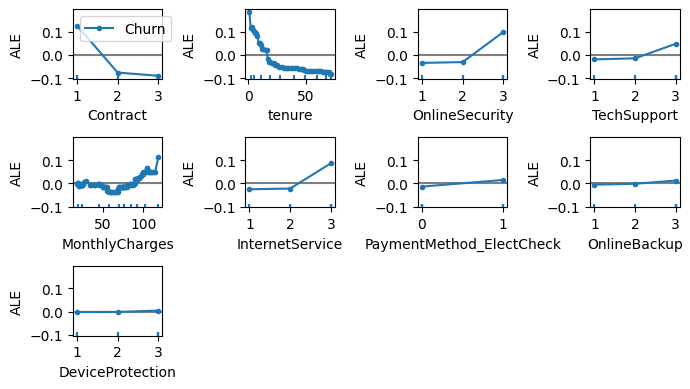

In [ ]:
# After generating the ALE values we can plot them.
# in this example, we choose to plot the ALE only for the 4 important features (from XGBoost fi)

# get the important features
important_features = feat_imp[feat_imp > 0].index.tolist()

# plot for the important features ONLY, and also ONLY for the positive class "survived"
plot_ale(exp_model, # explanation object
         features=important_features, # if we do not specify a list of features here, the ALE will be plotted for all of the features provided in the X_test
         targets=target_names[1:], # if we do not specify target names, we will get ALE values for both classes: "did not survice" and "survived"; this parameter is a list so note the slicing
         n_cols=4, # specify how many columns in the plot we want
         fig_kw={'figwidth': 7, 'figheight': 4}); # specify figure size

**ALE Interpretation Notes:**
 * On the X-axis, you'll find the different values of each feature, while the Y-axis shows ALE values in terms of probability. This is because we used the predict_proba function with the ALE explainer.

 * It's important to note that all the graphs are centered around 0, and the ALE values are in relative probability units with respect to the mean feature effect (mean ALE values for a feature).

---

# SHAP - TreeSHAP

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model, X_train)

In [ ]:
# make sure it says interventional here, otherwise
# it is using a different way to calculate SHAP

explainer.feature_perturbation

'interventional'

In [ ]:
# what are we explaining?

explainer.model_output

'raw'

When the model output is set to "raw", the explainer is explaining the log of the Odds!

**Important**

If we want to explain probabilities instead of log(Odds), we need to set the `model_output` parameter to `"probabilities"`. But unfortunately, that is only supported for binary classification.

As we are working with multi-class, if we want to explain the probabilities instead, we should use the `PermutationExplainer` or directly the `Explainer` and let `SHAP` choose what's best.

In [ ]:
# obtain the shap values

shap_values = explainer(X_test)

In [ ]:
# there are 1 shapley value per class

shap_values

.values =
array([[[ 0.05858978, -0.05858978],
        [ 0.0292447 , -0.0292447 ],
        [-0.02129414,  0.02129415],
        ...,
        [ 0.11478396, -0.11478396],
        [ 0.01286875, -0.01286875],
        [ 0.01396973, -0.01396973]],

       [[-0.1216996 ,  0.1216996 ],
        [-0.06233209,  0.06233209],
        [-0.08056128,  0.08056128],
        ...,
        [-0.09534769,  0.09534769],
        [-0.02058761,  0.02058761],
        [ 0.01265161, -0.01265161]],

       [[ 0.03726379, -0.03726379],
        [ 0.02197262, -0.02197262],
        [ 0.05770761, -0.05770761],
        ...,
        [ 0.07562283, -0.07562284],
        [-0.01773863,  0.01773864],
        [ 0.00838824, -0.00838824]],

       ...,

       [[-0.06404765,  0.06404765],
        [ 0.03105067, -0.03105067],
        [ 0.06281339, -0.06281339],
        ...,
        [ 0.07126063, -0.07126063],
        [ 0.03817618, -0.03817619],
        [ 0.00787175, -0.00787175]],

       [[ 0.03827494, -0.03827494],
        [ 0.03017

## SHAP - Global Explanations

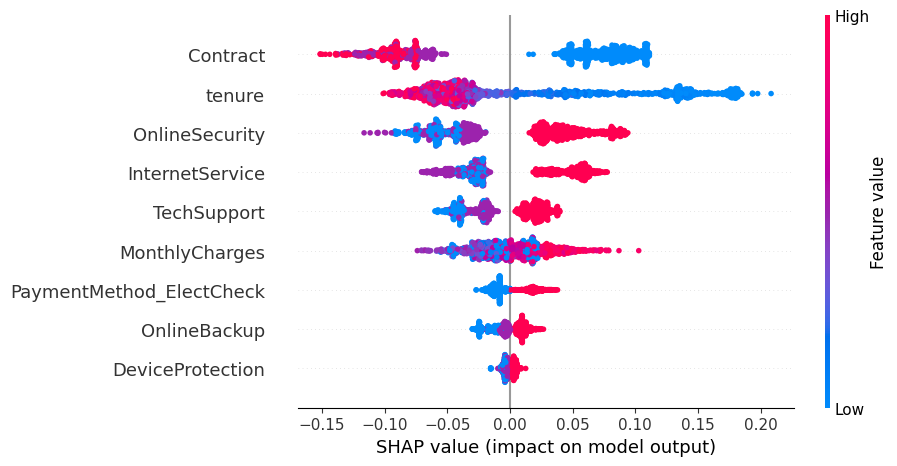

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1])

###SHAP Plot Interpretation

✅ 1. X-axis → SHAP value

* Measures how much each feature contributes to the prediction of class 1, relative to the average prediction.
  * Values > 0 → push the prediction toward class 1.
  * Values < 0 → push the prediction away from class 1.

✅ 2. Y-axis → Features
  * Ordered top to bottom by mean absolute SHAP value (i.e., most important to least).

* Top features have the biggest overall influence on the model’s class 1 predictions.

✅ 3. Each dot → One instance (row of your dataset)

* Dot position on x-axis = how much this feature contributed to predicting class 1 for that instance.

* Dot color = feature value (usually red = high, blue = low)

## SHAP value Plots

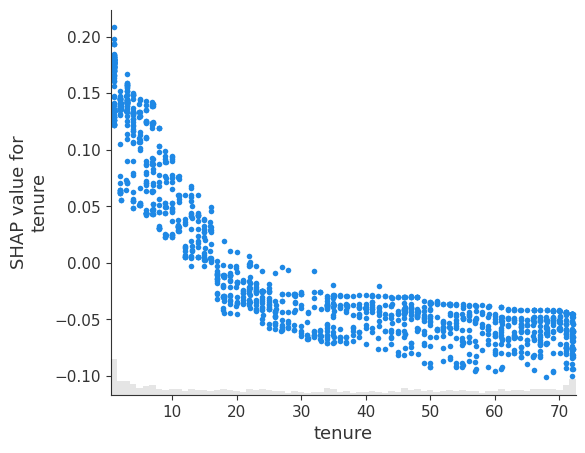

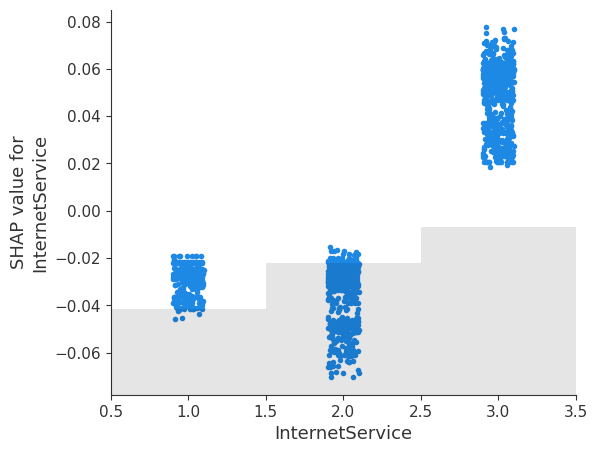

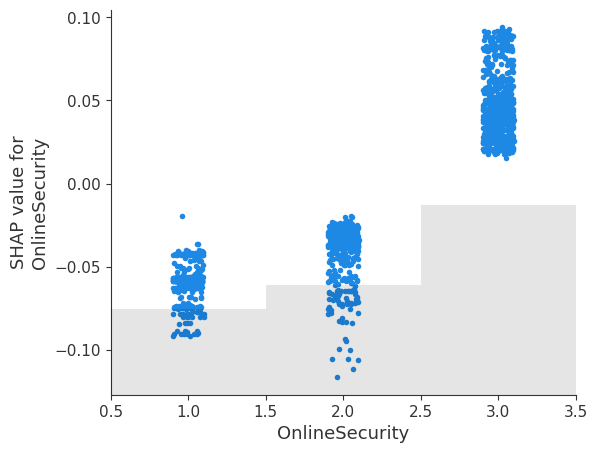

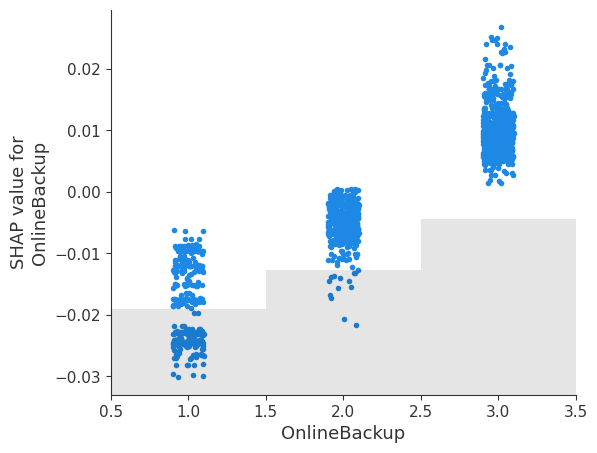

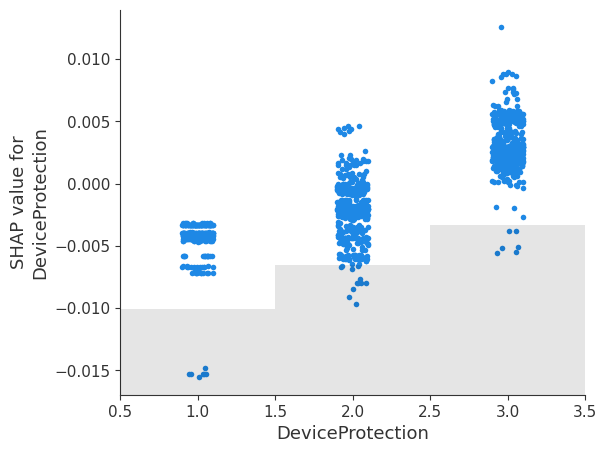

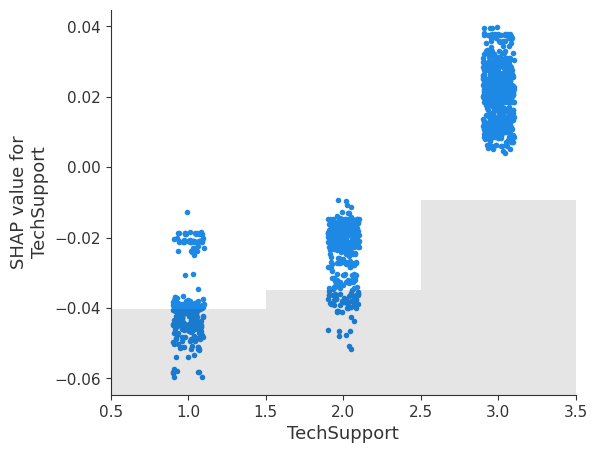

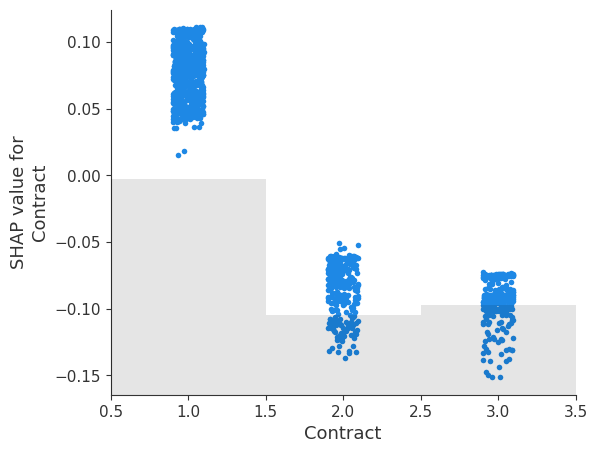

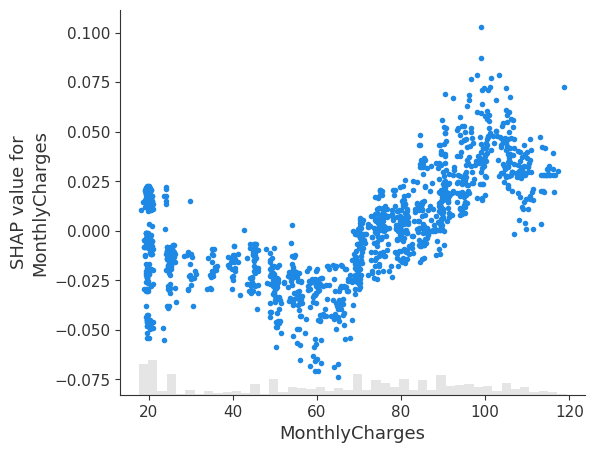

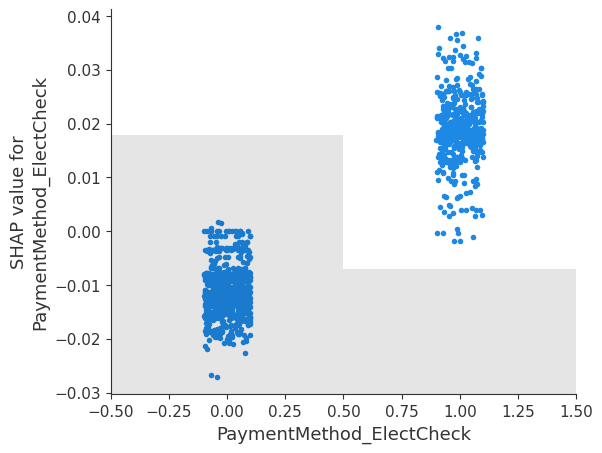

In [ ]:
for feature in X_test.columns:
    shap.plots.scatter(shap_values[:,feature,1])

# SHAP - Local Explanations

In [ ]:
# examine non-churned user
index = 0
print(y_test.iloc[index])
print(y_pred[index])
print(y_pred_prob[index])
X_test.iloc[index]

Churn    0
Name: 971, dtype: int64
0
0.03853764204914732


,971
tenure,59.00
InternetService,2.00
OnlineSecurity,3.00
OnlineBackup,2.00
DeviceProtection,3.00
TechSupport,2.00
Contract,3.00
MonthlyCharges,75.95
PaymentMethod_ElectCheck,0.00


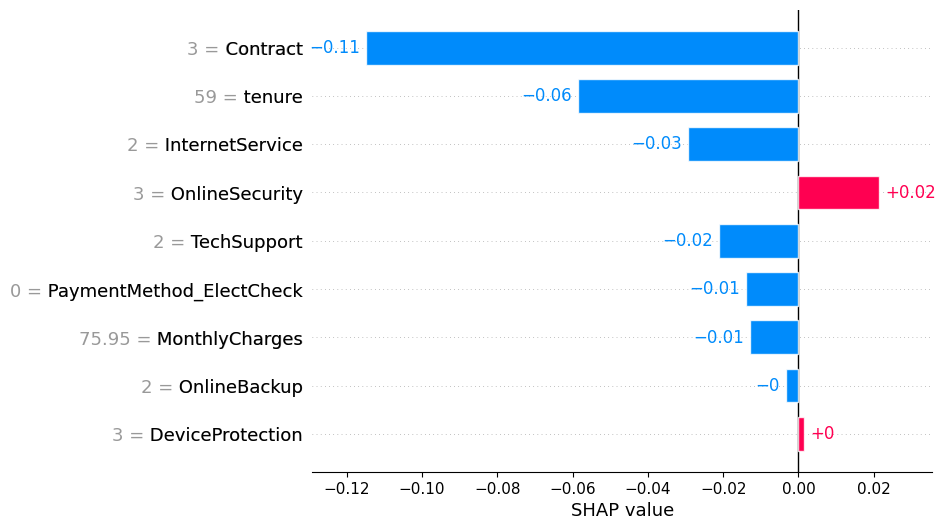

In [ ]:
shap.plots.bar(shap_values[index, :, 1], max_display=14)

---